# Exceptional Work - LSTM RNN For Daily Revenue

#### Fork of https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo


Below we explore the applicability of a Long-Short Term Memory Neural Network for predicting revenue movements on a daily basis. Using Keras, a deep learning library written on top of Google's Tensorflow, we attempt to implement a predictive model. 

In [2]:
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print( 'yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print( "Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data,
    # in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run 
    # predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(len(data)//prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

Using TensorFlow backend.


In [3]:
import pandas as pd
import datetime as dt
df = pd.read_csv('online_retail.csv')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [5]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)

In [7]:
# run once, intensive process
df['item_rev'] = df.Quantity * df.UnitPrice 
df = df.drop(['StockCode','Description','Quantity',
              'UnitPrice','CustomerID','Country'],1)
df.InvoiceDate = list(map(lambda x: x.replace(hour=0,
                    minute=0,second=0, microsecond=0),
                          df.InvoiceDate))

In [8]:
data = df.groupby(['InvoiceDate'])['item_rev'].sum()
data.to_csv('rnn.csv',index=False)

In [9]:
df2 = pd.read_csv('rnn.csv',header=None)

In [10]:
X_train, y_train, X_test, y_test = load_data('rnn.csv', 7, True)

In [11]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=7,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

compilation time :  0.026914119720458984


In [12]:
#Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=10,
    validation_split=0.05)

Train on 254 samples, validate on 14 samples
Epoch 1/10
254/254 [==============================] - 1s 5ms/step - loss: 2.3221 - val_loss: 2.2598
Epoch 2/10
254/254 [==============================] - 0s 227us/step - loss: 2.1903 - val_loss: 2.1158
Epoch 3/10
254/254 [==============================] - 0s 208us/step - loss: 2.0906 - val_loss: 1.9788
Epoch 4/10
254/254 [==============================] - 0s 206us/step - loss: 1.9905 - val_loss: 1.8392
Epoch 5/10
254/254 [==============================] - 0s 230us/step - loss: 1.9067 - val_loss: 1.6941
Epoch 6/10
254/254 [==============================] - 0s 234us/step - loss: 1.8167 - val_loss: 1.5479
Epoch 7/10
254/254 [==============================] - 0s 239us/step - loss: 1.7359 - val_loss: 1.4070
Epoch 8/10
254/254 [==============================] - 0s 230us/step - loss: 1.6521 - val_loss: 1.2704
Epoch 9/10
254/254 [==============================] - 0s 227us/step - loss: 1.5523 - val_loss: 1.1470
Epoch 10/10
254/254 [==================

# Summary of Review

Reviewing the predictions of our LSTM model, we see that the model naturally smoothed the trends, removing most volatility and mapping general macro trends in revenue. Our final model looks at the weekly trends using a range of 7 days for memory. While we expected this window to yield a more representative model, we found that as window size was reduced from an initial size of 50 to 7, volatility of our predicted model increased, but not to the extent that it predicted swings in the short-term. 

Our final output maps to the macro movements, which is an interesting result. It highlights both the limitations ands strengths of LSTM methods on small samples. The memory weight vector allows the data to move as important underlying trends change but is unable to identify very short-term movements. As noted in our association rule mining, there are strong seasonal influencers on this purchase data. LSTM does not highlight this on a timescale smaller than annual. 

## Predictions

yo


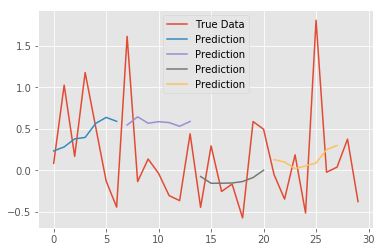

In [13]:
#Step 4 - Plot the predictions!
import matplotlib.pyplot as plt
plt.style.use('ggplot')
predictions = predict_sequences_multiple(model, X_test, 7, 7)
plot_results_multiple(predictions, y_test, 7)

## Reality

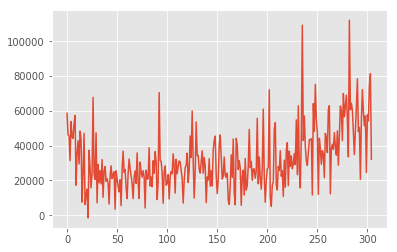

In [14]:
%matplotlib inline
plt.plot(df2[0])